Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Greykite Forecast Baseline

* Greykite grid search reference: https://linkedin.github.io/greykite/docs/0.1.0/html/gallery/quickstart/0500_grid_search.html
* For more about model summary output: https://linkedin.github.io/greykite/docs/0.1.0/html/pages/autodoc/doc.html#greykite.algo.common.model_summary.ModelSummary.get_coef_summary

In [17]:
import plotly
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import HTML

from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_ts(ts, title, exclude_cols):
    %pylab inline
    plt.figure(figsize=(20,3))
    for col in ts.columns:
        if col in exclude_cols:
            continue
        fig = plt.plot(ts[col], label=col)
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [3]:
ts_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/sales_ts.pkl')
print(ts_df.shape)

ts_df.head()

(942, 1)


Daily_Sales
Date                   
2013-01-01        58165
2013-01-02      4822042
2013-01-03      4415571
2013-01-04      4587035
2013-01-05      4078281

Populating the interactive namespace from numpy and matplotlib


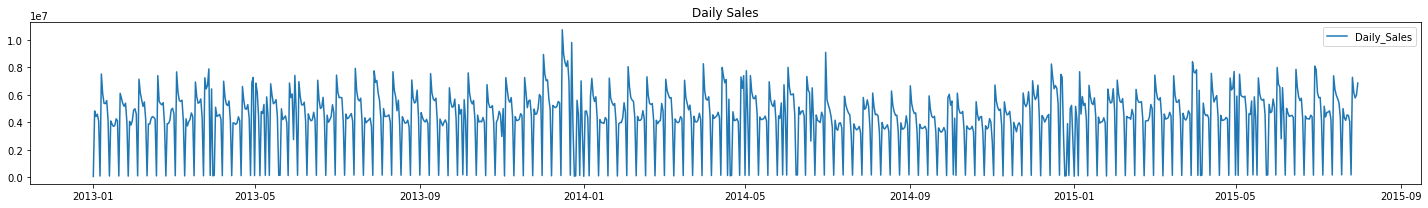

In [4]:
plot_ts(ts_df, title='Daily Sales', exclude_cols=['Date'])

In [5]:
ts_df = ts_df.reset_index()
back_test_period = ts_df.loc[ts_df['Date'] >= '2015-03-01']['Date'].nunique()

print(back_test_period)

153


## Basic Config

In [6]:
metadata = MetadataParam(
     time_col="Date",
     value_col="Daily_Sales",
     freq="D"
    )

forecaster = Forecaster()  
result = forecaster.run_forecast_config(  
     df=ts_df,
     config=ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=back_test_period,  # the number of steps to forecast ahead
         coverage=0.95,         # 95% upper bound and lower bound prediction intervals
         metadata_param=metadata
     )
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


### Cross Validation

* Default score metric is MAPE

In [7]:
grid_search = result.grid_search
cv_results = summarize_grid_search_results(
     grid_search=grid_search,
     decimals=2,
     cv_report_metrics=None,  # It saves space in the printed output. Remove to show all available metrics and columns.
     column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])

# Transposes to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

params                                  []
rank_test_MAPE                           1
mean_test_MAPE                      148.28
split_test_MAPE   (185.26, 111.11, 148.47)
mean_train_MAPE                     149.64
split_train_MAPE  (148.18, 162.61, 138.11)
mean_fit_time                        13.29
mean_score_time                       1.71

### Backtest

* The best model from cross validation is refit on data prior to the backtest period
* Greykite's MAPE formula is slightly different from sklearn's MAPE: https://github.com/linkedin/greykite/blob/master/greykite/common/evaluation.py#L409
  * In greykite, its MAPE will multiply 100

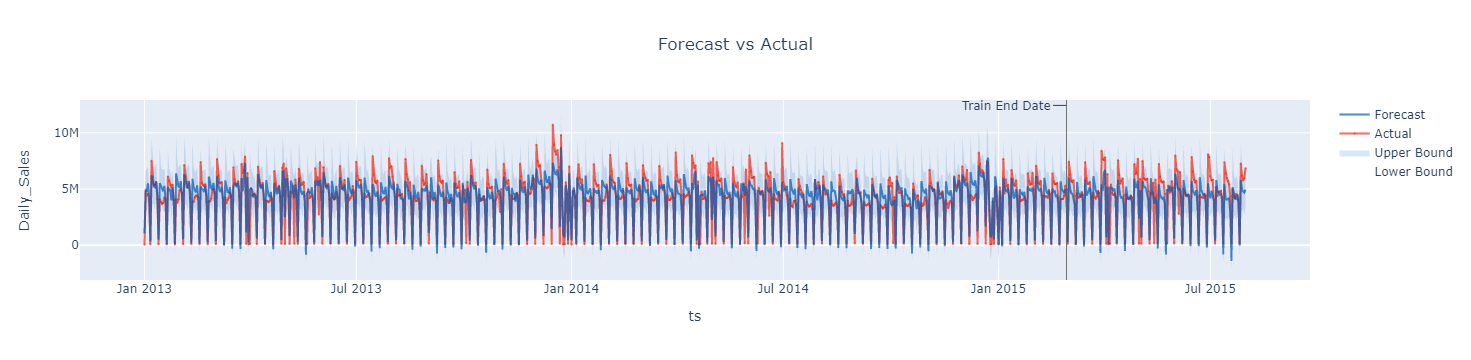

In [8]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

In [9]:
backtest.df.head().round(2)

Date   actual    forecast  forecast_lower  forecast_upper
0 2013-01-01    58165  1045350.19      -892660.77      2983361.16
1 2013-01-02  4822042  4904151.46      3315043.17      6493259.75
2 2013-01-03  4415571  4856790.09      2872678.38      6840901.81
3 2013-01-04  4587035  5504051.76      3982258.66      7025844.87
4 2013-01-05  4078281  4409124.86      3573981.86      5244267.87

In [10]:
backtest_eval = defaultdict(list)
for metric, value in backtest.train_evaluation.items():
    backtest_eval[metric].append(value)
    backtest_eval[metric].append(backtest.test_evaluation[metric])
metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
metrics

train  \
CORR                                                          0.889244   
R2                                                            0.790616   
MSE                                                 938983161023.42395   
RMSE                                                     969011.434929   
MAE                                                      709118.765238   
MedAE                                                     534509.19319   
MAPE                                                         88.833355   
MedAPE                                                       14.673014   
sMAPE                                                        17.087649   
Q80                                                      354559.382619   
Q95                                                      354559.382619   
Q99                                                      354559.382619   
OutsideTolerance1p                                            0.974651   
OutsideTolerance2p                                            0.927757   
OutsideTolerance3p                                            0.892269   
OutsideTolerance4p                                            0.858048   
OutsideTolerance5p                                            0.821293   
Outside Tolerance (fraction)                                      None   
R2_null_model_score                                               None   
Prediction Band Width (%)                                   354.781322   
Prediction Band Coverage (fraction)                           0.956907   
Coverage: Lower Band                                          0.453739   
Coverage: Upper Band                                          0.503169   
Coverage Diff: Actual_Coverage - Intended_Coverage            0.006907   

                                                                    test  
CORR                                                            0.856542  
R2                                                              0.686096  
MSE                                                 1616654064470.013184  
RMSE                                                       1271477.11913  
MAE                                                        949535.859902  
MedAE                                                      787642.236704  
MAPE                                                          117.490327  
MedAPE                                                         19.250956  
sMAPE                                                          20.274532  
Q80                                                        619756.615973  
Q95                                                        692250.958984  
Q99                                                        711582.783786  
OutsideTolerance1p                                              0.980392  
OutsideTolerance2p                                              0.934641  
OutsideTolerance3p                                              0.908497  
OutsideTolerance4p                                              0.856209  
OutsideTolerance5p                                              0.836601  
Outside Tolerance (fraction)                                        None  
R2_null_model_score                                                 None  
Prediction Band Width (%)                                     331.290518  
Prediction Band Coverage (fraction)                             0.849673  
Coverage: Lower Band                                            0.267974  
Coverage: Upper Band                                            0.581699  
Coverage Diff: Actual_Coverage - Intended_Coverage             -0.100327

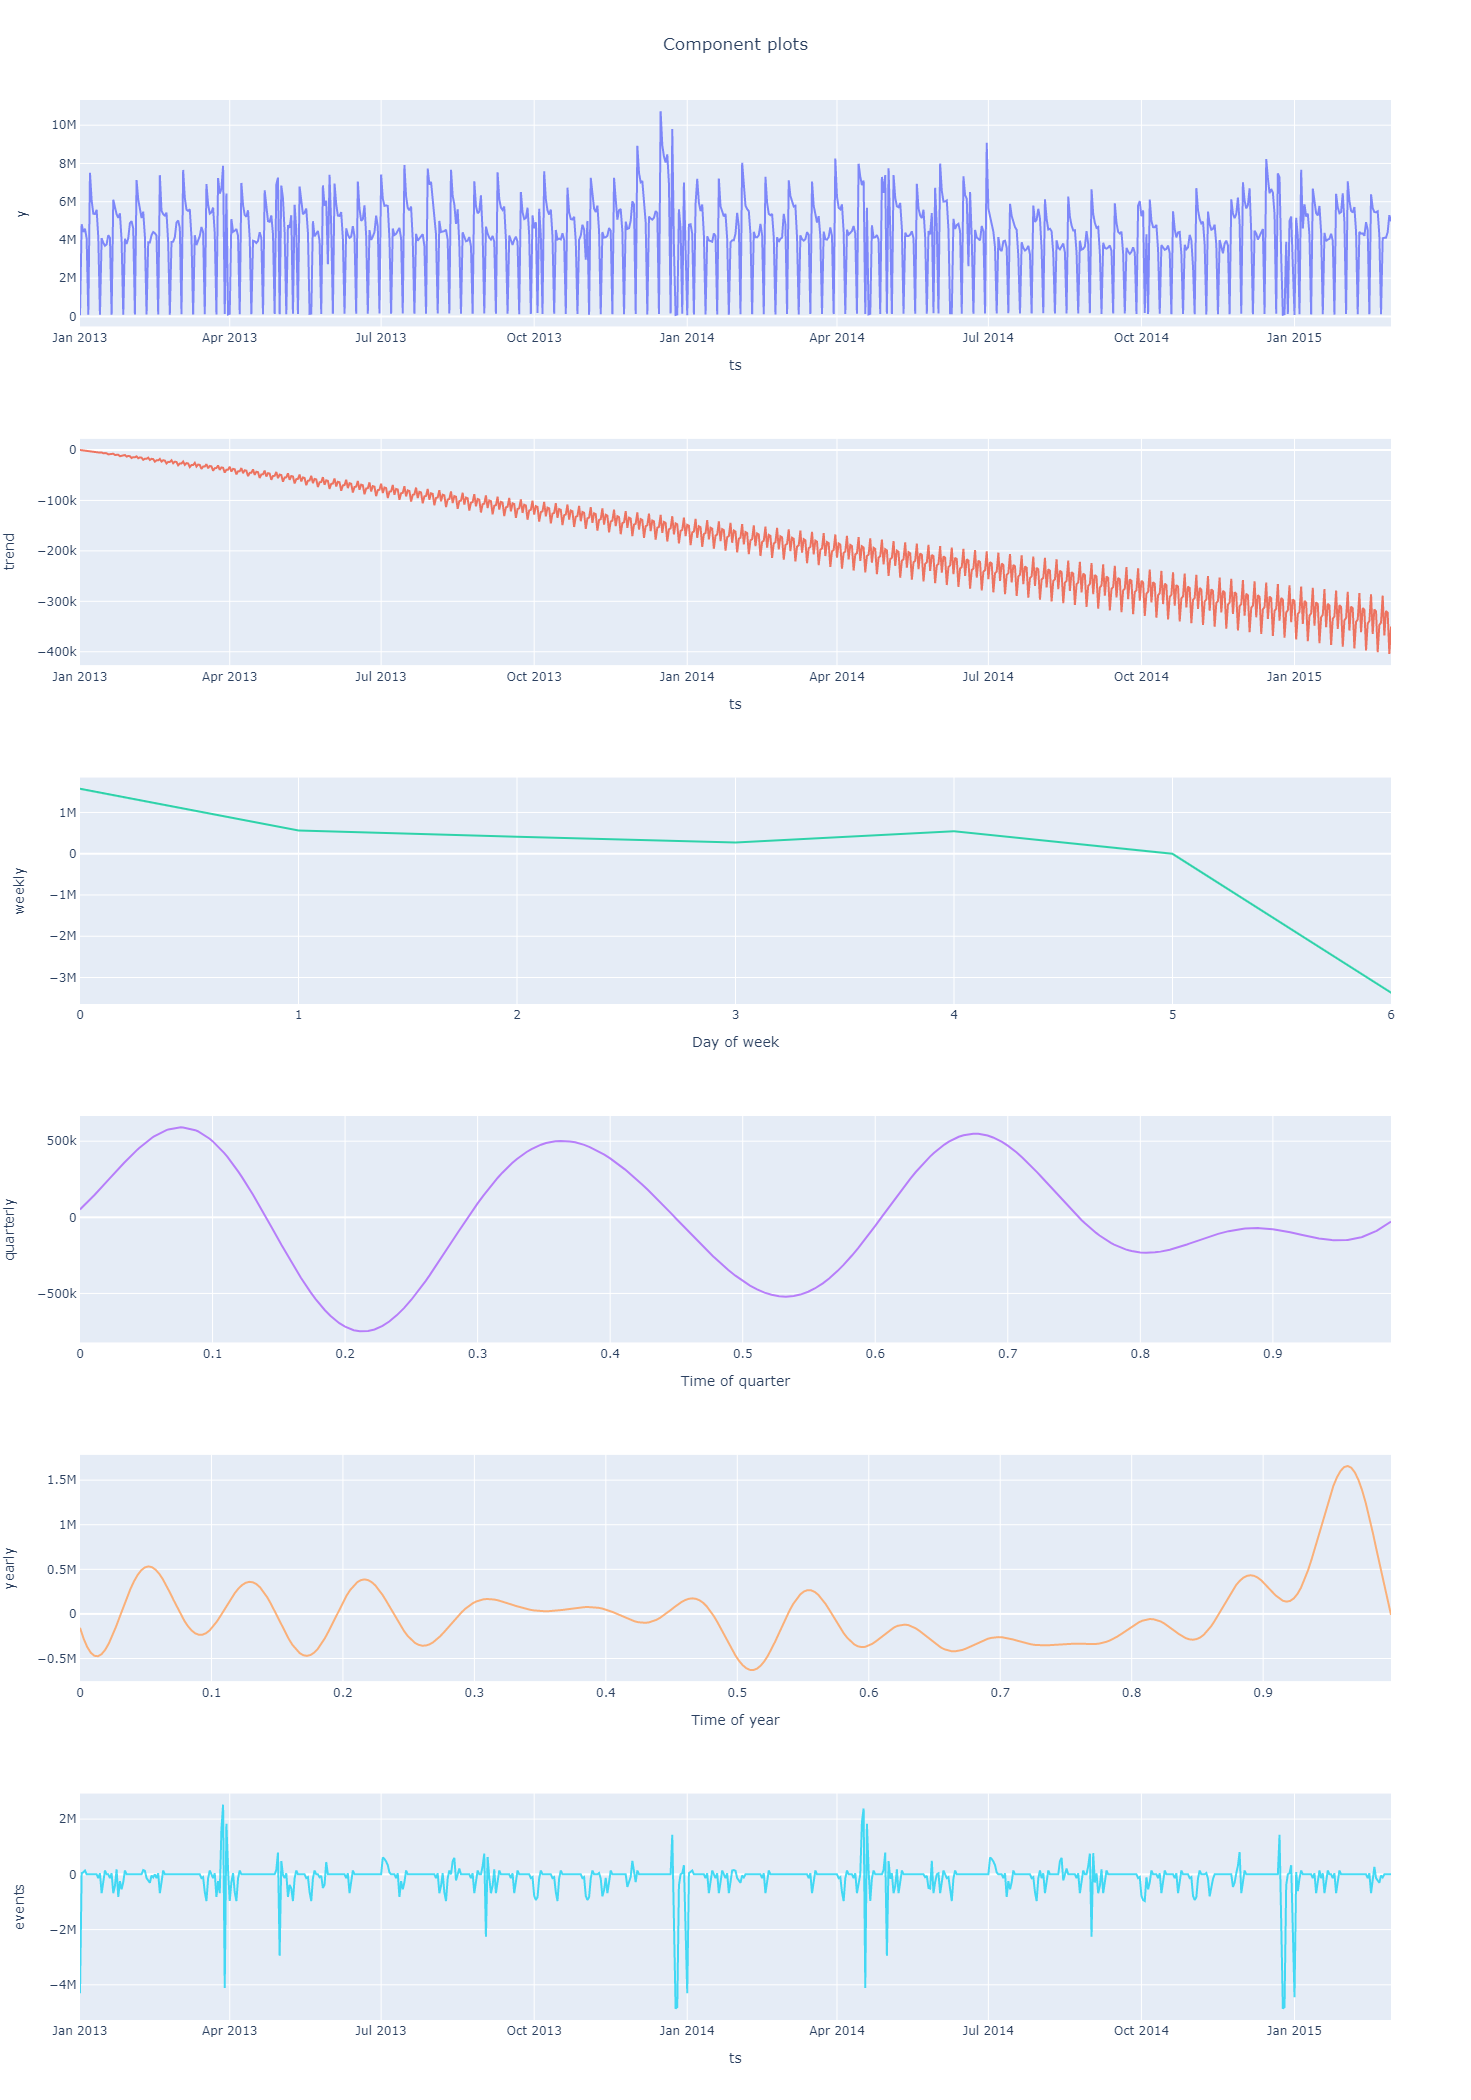

In [11]:
fig = backtest.plot_components()
plotly.io.show(fig)

### Forecast

* In greykite, backtest is forecasting with ground truth, while forecast doesn't have ground truth

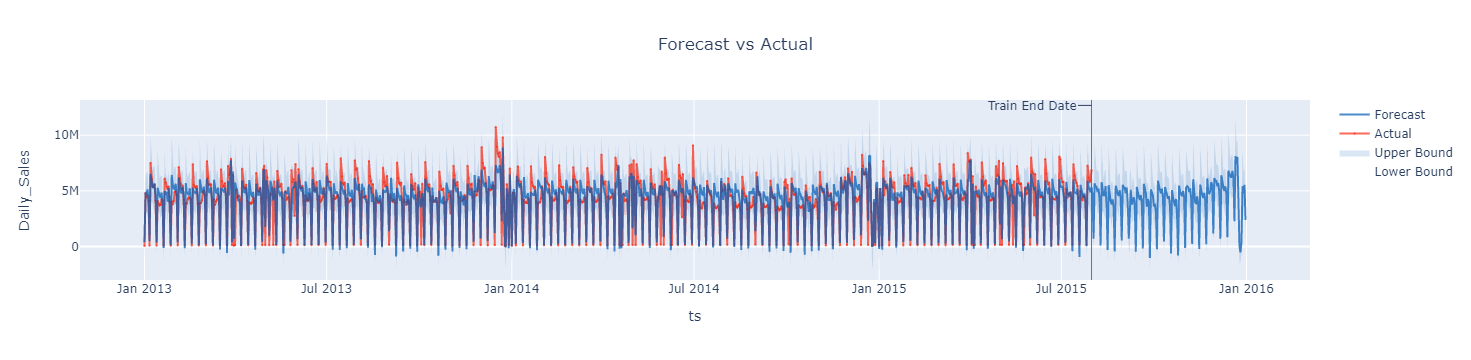

In [12]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [13]:
forecast.df.tail().round(2)

Date  actual    forecast  forecast_lower  forecast_upper
1090 2015-12-27     NaN   380948.72      -606975.10      1368872.53
1091 2015-12-28     NaN  5417666.54      1951213.96      8884119.11
1092 2015-12-29     NaN  4769592.07      2852999.62      6686184.51
1093 2015-12-30     NaN  5532965.64      4068094.45      6997836.83
1094 2015-12-31     NaN  2392791.26       413199.83      4372382.70

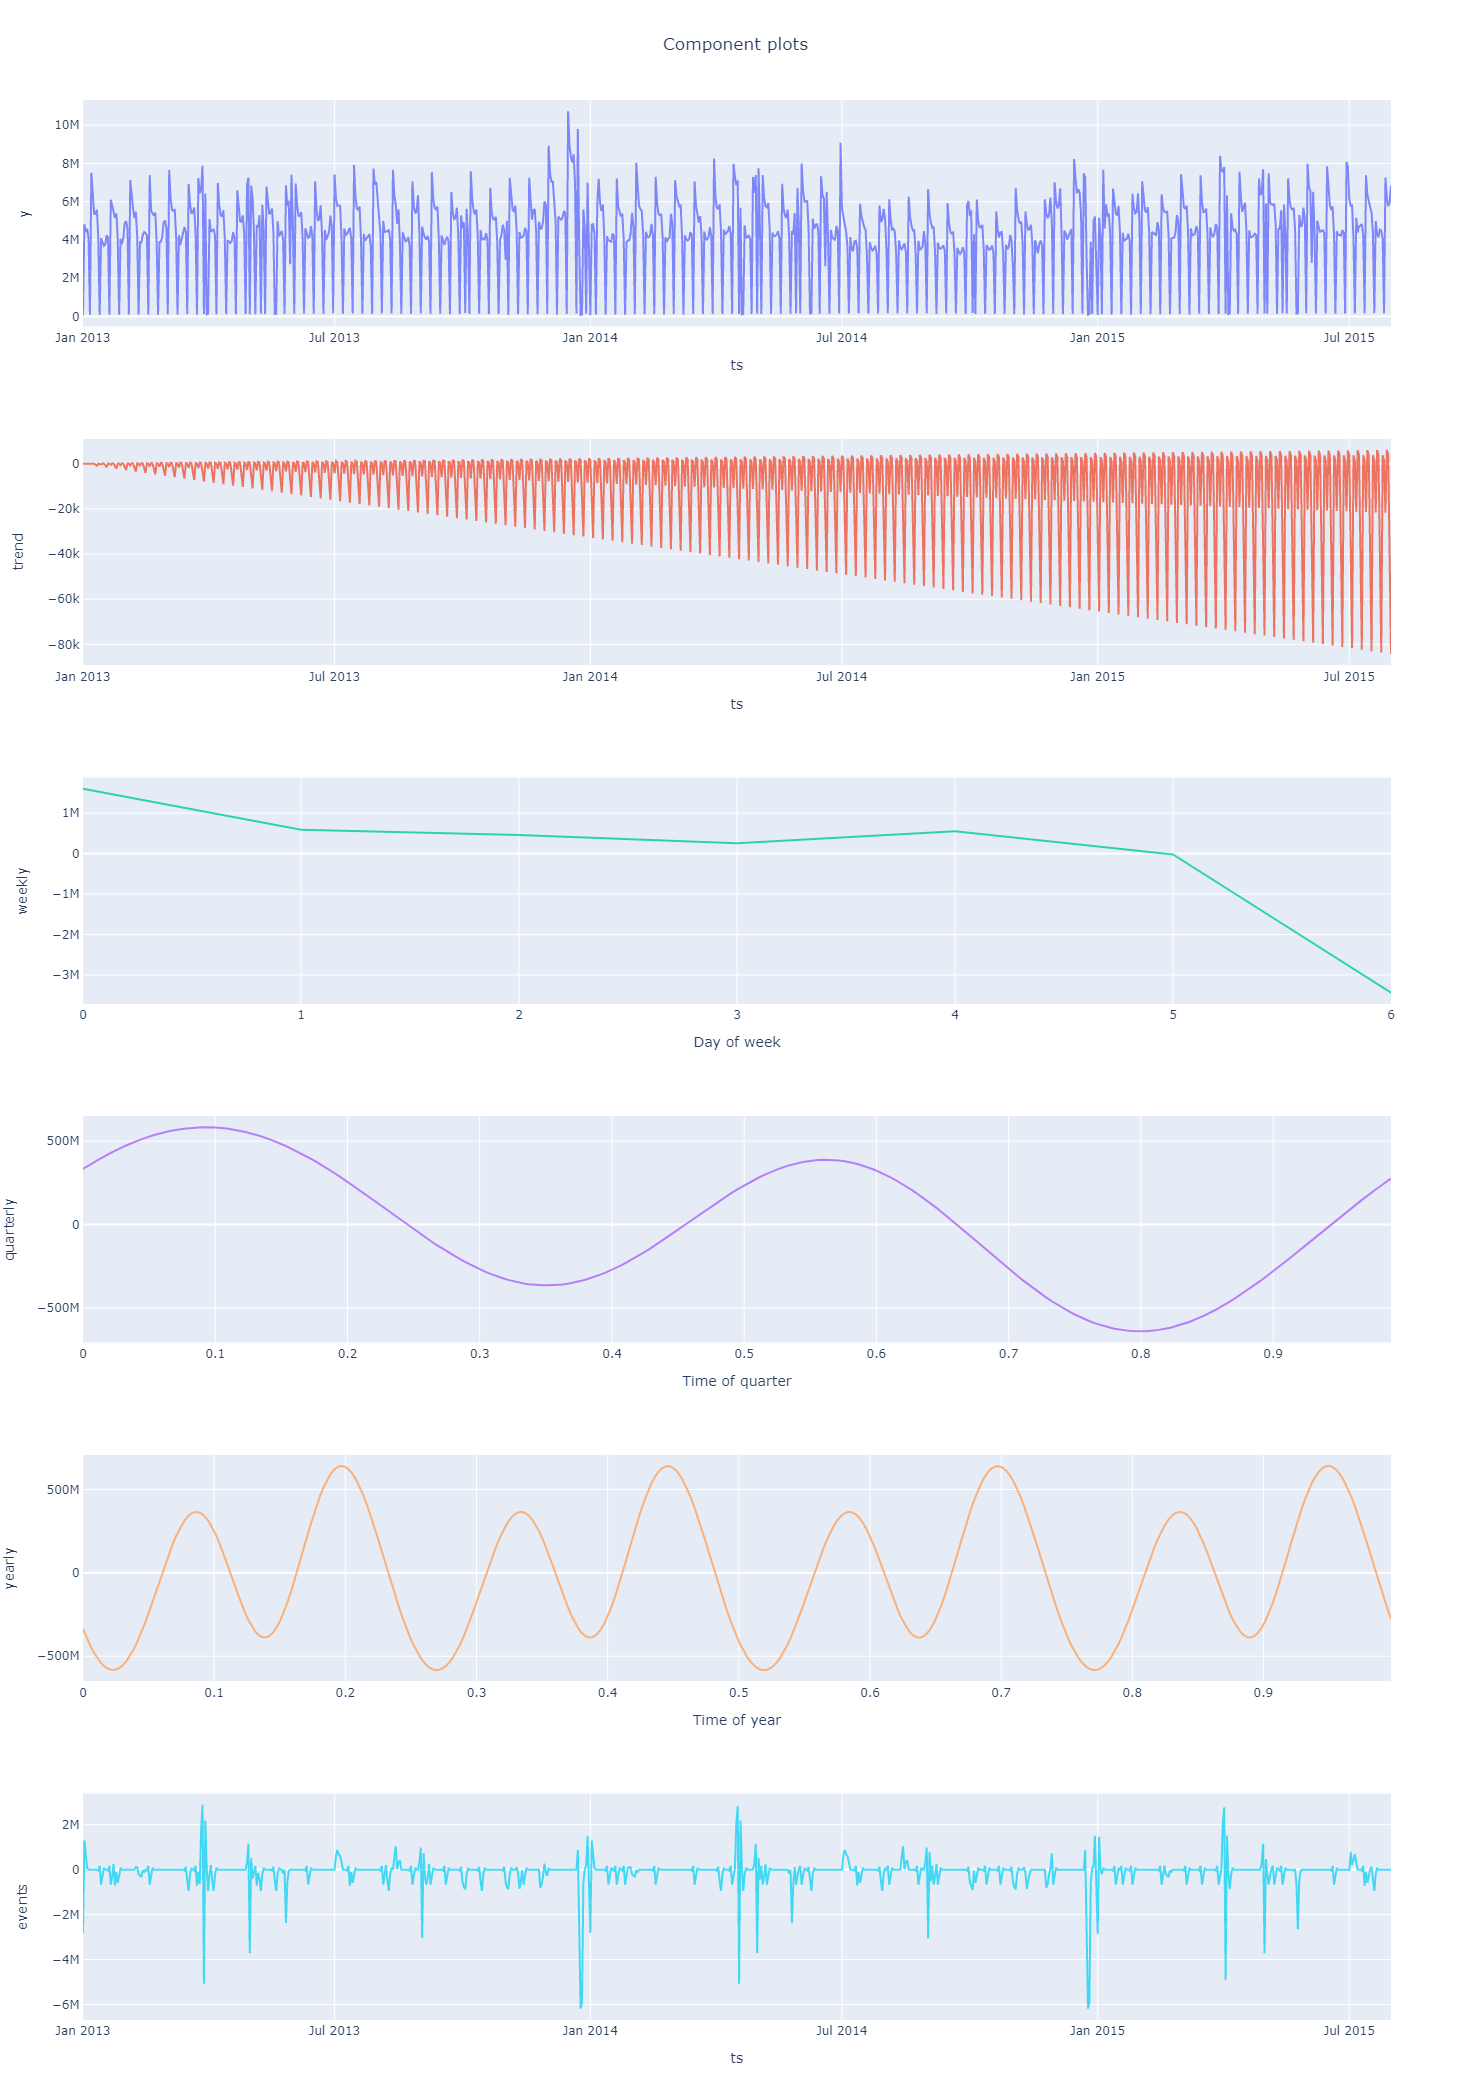

In [14]:
fig = forecast.plot_components()
plotly.io.show(fig)

### Model Summary

In [20]:
summary = result.model[-1].summary()  # -1 retrieves the estimator from the pipeline
coef_summary_df = summary.info_dict['coef_summary_df']
coef_summary_df = coef_summary_df.sort_values(by='Pr(>)_boot')
HTML(coef_summary_df.to_html())

In [17]:
# get a summary of interaction features
summary.get_coef_summary(is_interaction=True, return_df=True)

           Pred_col   Estimate  Std. Err Pr(>)_boot sig. code                   95%CI
     is_weekend:ct1     6316.0 3.069e+04      0.840           (-5.952e+04, 6.419e+04)
  str_dow_2-Tue:ct1  1.083e+04 1.085e+05      0.922           (-2.183e+05, 2.024e+05)
  str_dow_3-Wed:ct1  1.001e+04 7.697e+04      0.886           (-1.345e+05, 1.702e+05)
  str_dow_4-Thu:ct1    -6591.0 7.185e+04      0.910           (-1.503e+05, 1.297e+05)
  str_dow_5-Fri:ct1 -2.424e+04 5.932e+04      0.678           (-1.330e+05, 8.444e+04)
  str_dow_6-Sat:ct1     3635.0 6.731e+04      0.932           (-1.196e+05, 1.436e+05)
  str_dow_7-Sun:ct1     2681.0 8.763e+04      0.974           (-1.861e+05, 1.666e+05)
ct1:sin1_tow_weekly  2.024e+04 3.961e+04      0.600           (-6.186e+04, 9.240e+04)
ct1:cos1_tow_weekly  2.837e+04 9.155e+04      0.752           (-1.578e+05, 2.179e+05)
ct1:sin2_tow_weekly    -8616.0 4.482e+04      0.830           (-9.319e+04, 7.964e+04)
ct1:cos2_tow_weekly -3.931e+04 8.242e+04      0.632   

Pred_col      Estimate       Std. Err  Pr(>)_boot sig. code  \
0        is_weekend:ct1   6316.293935   30688.765631       0.840             
1     str_dow_2-Tue:ct1  10831.488992  108466.246235       0.922             
2     str_dow_3-Wed:ct1  10011.007333   76972.543787       0.886             
3     str_dow_4-Thu:ct1  -6590.920963   71846.198794       0.910             
4     str_dow_5-Fri:ct1 -24236.551827   59317.827509       0.678             
5     str_dow_6-Sat:ct1   3635.455771   67311.135859       0.932             
6     str_dow_7-Sun:ct1   2681.121480   87628.050482       0.974             
7   ct1:sin1_tow_weekly  20244.244537   39605.260067       0.600             
8   ct1:cos1_tow_weekly  28372.607663   91546.018312       0.752             
9   ct1:sin2_tow_weekly  -8616.140207   44817.756025       0.830             
10  ct1:cos2_tow_weekly -39312.659166   82415.172297       0.632             

                                        95%CI  is_intercept  is_time_feature  \
0    [-59524.233347279645, 64186.54434779863]             0                1   
1    [-218276.60758159496, 202365.8411270174]             0                1   
2    [-134522.98511330286, 170244.1827248831]             0                1   
3   [-150307.58014483965, 129683.67958222223]             0                1   
4    [-133047.48453910399, 84436.31066016351]             0                1   
5   [-119602.34721617393, 143597.00845161272]             0                1   
6   [-186118.11907169636, 166593.28282615807]             0                1   
7      [-61857.82695557858, 92401.8737945151]             0                1   
8   [-157780.35080432153, 217912.75016910094]             0                1   
9     [-93194.39993458874, 79639.00490392663]             0                1   
10    [-179914.339529355, 133059.41018072833]             0                1   

    is_event  is_trend  is_seasonality  is_lag  is_regressor  is_interaction  
0          0         1               0       0             0               1  
1          0         1               0       0             0               1  
2          0         1               0       0             0               1  
3          0         1               0       0             0               1  
4          0         1               0       0             0               1  
5          0         1               0       0             0               1  
6          0         1               0       0             0               1  
7          0         1               1       0             0               1  
8          0         1               1       0             0               1  
9          0         1               1       0             0               1  
10         0         1               1       0             0               1